In [95]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [181]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [97]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [98]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [99]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)



In [100]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [101]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [102]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [103]:
# Explore the table measurement to find the columns
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [104]:
# Explore the table measurement to find the columns

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [252]:
# Find the most recent date in the data set.

# Total dates
session.query(func.count(measurement.date)).all()

[(19550,)]

In [253]:
# Determine the latest Date
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date[0]


'2017-08-23'

In [254]:
query_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d') - dt.timedelta(days = 366)
query_date

datetime.datetime(2016, 8, 22, 0, 0)

In [255]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= query_date, measurement.prcp >=0).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns=['date', 'precipitation'])
results_df = results_df.set_index('date')

# Sort the dataframe by date
results_df = results_df.sort_values(by='date', axis=0, ascending=True)
results_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [256]:
# Count of the results
results_df.count()

precipitation    2021
dtype: int64

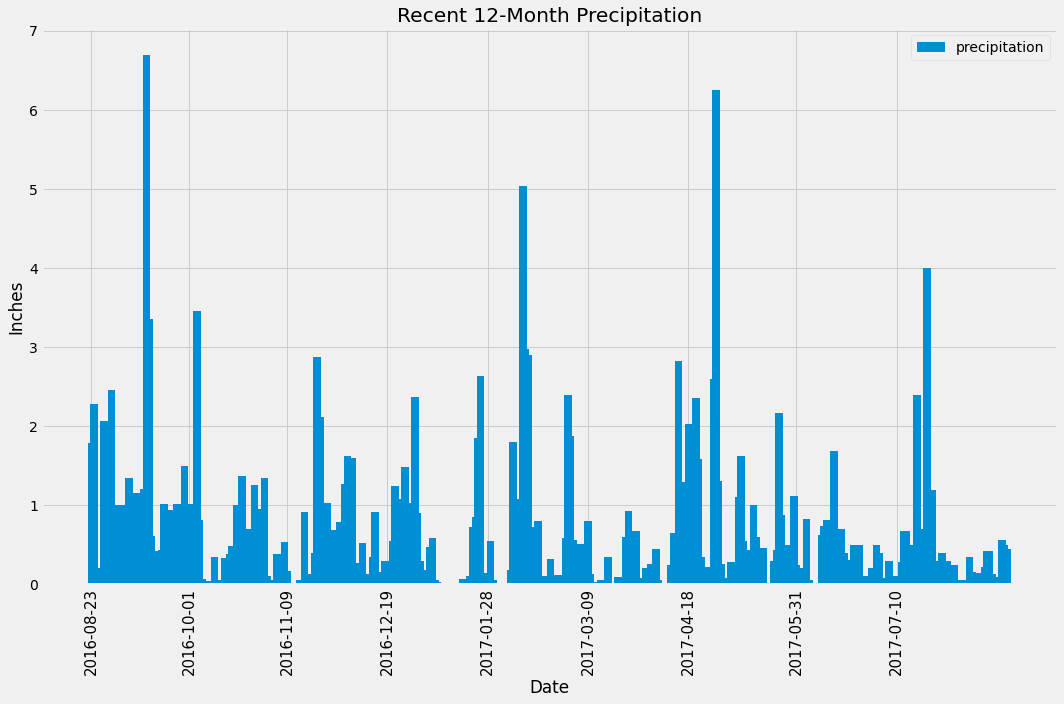

In [268]:
plt.figure(figsize=(15,10))
plt.bar(results_df.index, results_df['precipitation'], width=3, label="precipitation")
plt.xticks(rotation='vertical', fontsize=15)
plt.xticks(['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10'])
plt.title('Recent 12-Month Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc="upper right", fontsize="medium")
plt.tight_layout()
plt.show()

In [269]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [292]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(func.distinct(measurement.station))).all()
total_stations

[(9,)]

In [287]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station, station.station, station.name, func.count(measurement.station)]

station_results = session.query(*sel)\
    .filter(measurement.station == station.station)\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).all()
station_results_df = pd.DataFrame(station_results, columns=['Station_ID', 'Station_ID_S', 'Station_Name', 'Observation_Count'])
station_results_df = station_results_df.drop('Station_ID_S', axis=1)
station_results_df = station_results_df.set_index('Station_ID')
station_results_df

,Station_Name,Observation_Count
Station_ID,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [288]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station
active_station = station_results_df.index[0]
active_station


'USC00519281'

In [293]:
# Lowest Temperature
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == active_station).all()
lowest_temp

[(54.0,)]

In [294]:
#Highest Temperature
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == active_station).all()
highest_temp

[(85.0,)]

In [295]:
# Average Temperature
average_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == active_station).all()
average_temp

[(71.66378066378067,)]

In [297]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = session.query(measurement.tobs)\
    .filter(measurement.date >= query_date, measurement.station == active_station).all()
tobs_results

[(77.0,),
 (77.0,),
 (80.0,),
 (80.0,),
 (75.0,),
 (73.0,),
 (78.0,),
 (77.0,),
 (78.0,),
 (80.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (73.0,),
 (74.0,),
 (80.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (76.0,),
 (79.0,),
 (75.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (78.0,),
 (78.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (78.0,),
 (79.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (72.0,),
 (71.0,),
 (77.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (77.0,),
 (79.0,),
 (77.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (74.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (74.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (71.0,),
 (63.0,),
 (70.0,),
 (68.0,),
 (67.0,),
 (77.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (75.0,),
 (76.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (73.0,),


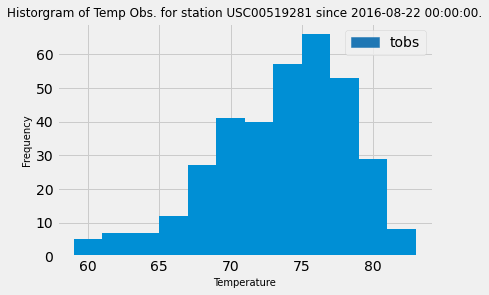

In [302]:
# Plot the results in a histogram with bins=12
import matplotlib.patches as mpatches

counts, bins = np.histogram(tobs_results_df, bins=12)
plt.hist(bins[:-1], bins, weights=counts)
plt.title(f'Historgram of Temp Obs. for station {active_station} since {query_date}.', fontdict={'fontsize':12})
plt.xlabel('Temperature',fontdict={'fontsize':10})
plt.ylabel('Frequency',fontdict={'fontsize':10})
legend = mpatches.Patch(color='#1f77b4', label='tobs')
plt.legend(handles=[legend])
plt.show()

# Close session

In [303]:
# Close Session
session.close()